# Assignment 6

In [107]:
import torch
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

### PART 1: Data Generation (The Exclusion Zone)

In [108]:
GROUP_NUMBER = 8

# Manual seed 
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


### PART 2: Splitting the Data & Parameter Initialization


In [109]:
# Split Data (70% Train, 30% Val)
indices = torch.randperm(X_full.size(0))
train_size = int(0.7 * X_full.size(0))

X_train, y_train = X_full[indices[:train_size]], y_full[indices[:train_size]]
X_val, y_val = X_full[indices[train_size:]], y_full[indices[train_size:]]

In [110]:
# Network Architecture
def init_weights(shape):
    return (torch.randn(shape) * torch.sqrt(torch.tensor(2.0 / shape[0]))).requires_grad_(True)

def init_bias(shape):
    return torch.zeros(shape, requires_grad=True)

# Layer 1
W1 = init_weights((2, 16))
b1 = init_bias((1, 16))

# Layer 2
W2 = init_weights((16, 16))
b2 = init_bias((1, 16))

# Layer 3
W3 = init_weights((16, 16))
b3 = init_bias((1, 16))

# Output Layer
W4 = init_weights((16, 1))
b4 = init_bias((1, 1))

parameters = [W1, b1, W2, b2, W3, b3, W4, b4]

 Here I have used He Initialization (std = sqrt(2/fan_in))
- The weights are plain tensors with requires_grad=true means they will accumulate gradients and can be updated manually

### PART 3: Activation & Loss Functions

In [111]:
def relu(z):
    return z.clamp(min=0)

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def forward_pass(X):
    z1 = torch.matmul(X, W1) + b1
    a1 = relu(z1)
    
    z2 = torch.matmul(a1, W2) + b2
    a2 = relu(z2)
    
    z3 = torch.matmul(a2, W3) + b3
    a3 = relu(z3)
    
    z4 = torch.matmul(a3, W4) + b4
    y_hat = sigmoid(z4)
    return y_hat

In [112]:
def binary_cross_entropy(y_pred, y_true):
    # Clamp to avoid log(0) which leads to NaN
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

### PART 4: Training Loop


In [113]:
learning_rate = 0.1
epochs = 2000

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):

    # Forward Pass
    y_pred_train = forward_pass(X_train)
    train_loss = binary_cross_entropy(y_pred_train, y_train)

    y_pred_val = forward_pass(X_val)
    val_loss = binary_cross_entropy(y_pred_val, y_val)

    # Accuracy
    train_acc = ((y_pred_train > 0.5) == y_train).float().mean()
    val_acc = ((y_pred_val > 0.5) == y_val).float().mean()

    # Backpropagation
    if any(p.grad is not None for p in parameters):
        for p in parameters:
            p.grad.zero_()

    train_loss.backward()

    # Manual Gradient Descent
    with torch.no_grad():
        for p in parameters:
            p -= learning_rate * p.grad

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc.item())
    val_accs.append(val_acc.item())


### PART 5: GDC HUD (Visualization Dashboard)


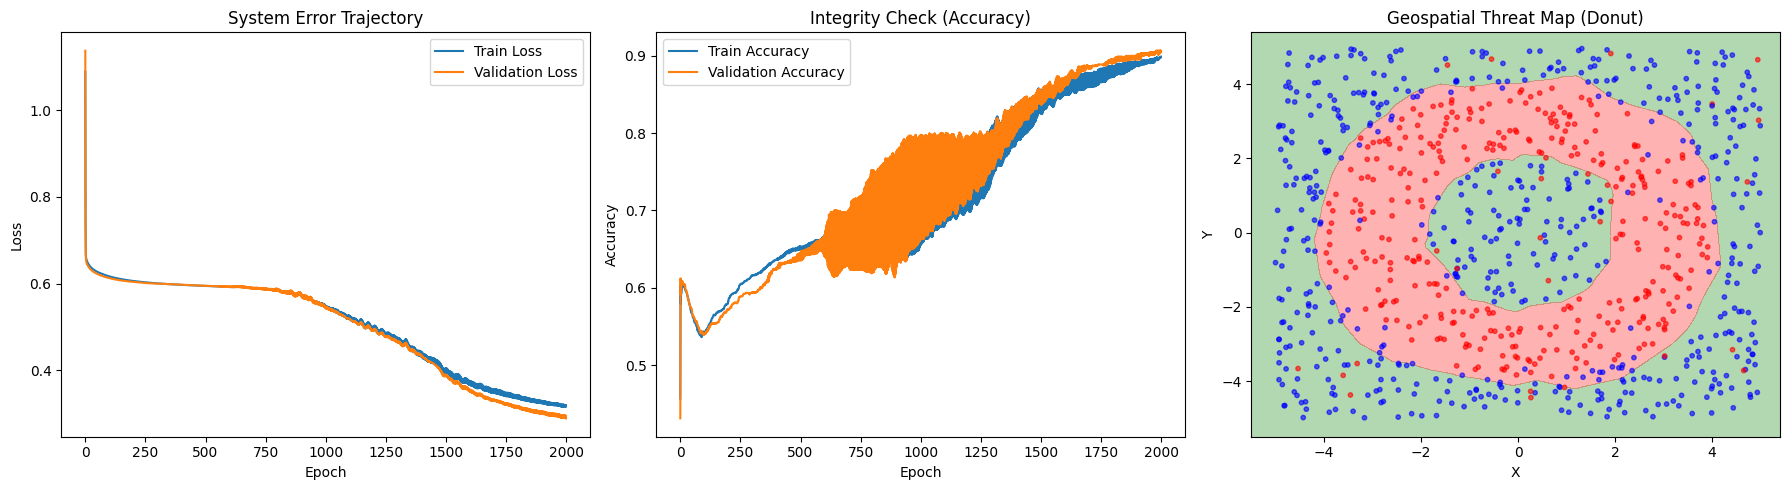

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. System Error Trajectory (Loss)
ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_title("System Error Trajectory")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()


# 2. Integrity Check (Accuracy)
ax[1].plot(train_accs, label='Train Accuracy')
ax[1].plot(val_accs, label='Validation Accuracy')
ax[1].set_title("Integrity Check (Accuracy)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()


# 3. Geospatial Threat Map (Decision Boundary)
h = 0.1
x_min, x_max = -5.5, 5.5
y_min, y_max = -5.5, 5.5

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

grid = torch.tensor(
    np.c_[xx.ravel(), yy.ravel()],
    dtype=torch.float32
)

with torch.no_grad():
    probs = forward_pass(grid).reshape(xx.shape)

ax[2].contourf(xx, yy, probs, levels=[0, 0.5, 1], 
               colors=['green', 'red'], alpha=0.3)

ax[2].scatter(
    X_val[:, 0], X_val[:, 1],
    c=y_val.flatten(),
    cmap='bwr',
    s=10,
    alpha=0.6
)

ax[2].set_title("Geospatial Threat Map (Donut)")
ax[2].set_xlabel("X")
ax[2].set_ylabel("Y")

plt.tight_layout()
plt.show()


### Conclusion 
- The decision boundary forms a closed non-linear ring, demonstrating that the MLP successfully learned the implicit radial geometry despite label noise and without explicit distance features